This notebook illustrates a few examples for using the package.

In [1]:
import importlib
import pandas as pd
import numpy as np
import localprojections as lp
import country_converter as coco

### Simplest example: no exogenous shocks

Get data from the `interest_rules_var_data` dataset in R's `lpirfs` package. This is the data used in Jorda (2005) to construct Figure 5 on p. 176 that we will replicate.

In [2]:
dfmacro = pd.read_csv('data/lplin_data.csv')

In [3]:
dfmacro.head()

,GDP_gap,Infl,FF
0,2.622792,1.600521,1.343333
1,3.468750,2.260075,1.500000
2,4.051261,2.887173,1.940000
3,3.795934,2.697188,2.356667
4,2.543033,3.959594,2.483333


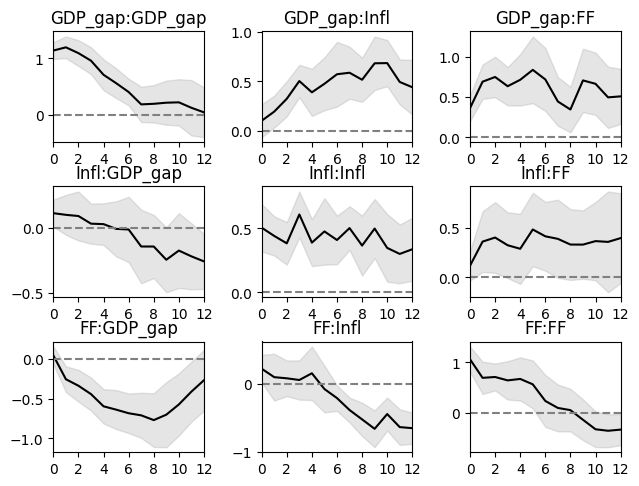

In [11]:
importlib.reload(lp)
lpmdl = lp.LP(dfmacro,maxlags=4)
out, _ = lpmdl.estimate(12)
lp.plot_irfs(out)

In [12]:
out

coef        lb        ub
impulse response horizon                              
GDP_gap GDP_gap  0        1.136925  0.987218  1.286632
                 1        1.193883  1.003449  1.384317
                 2        1.091217  0.862534  1.319900
                 3        0.957816  0.720563  1.195068
                 4        0.709088  0.436561  0.981615
...                            ...       ...       ...
FF      FF       8        0.057347 -0.361946  0.476641
                 9       -0.131874 -0.532712  0.268963
                 10      -0.318716 -0.670662  0.033230
                 11      -0.347983 -0.671792 -0.024174
                 12      -0.325483 -0.631458 -0.019508

[117 rows x 3 columns]

### Exogenous Shocks

Get data from the `ag_data` dataset in R's `lpirfs` package. This is the data used in Ramey and Zubairy (2018), used to construct Figure 12, middle row in the Supplemntary Appendix  (p. 35).

In [14]:
dfiv = pd.read_csv('data/lpliniv_data.csv')
dfiv.head()

,Gov,Tax,GDP
0,5.44825,5.85665,7.53358
1,5.51639,5.83983,7.51959
2,5.57626,5.79731,7.51593
3,5.59246,5.78464,7.52709
4,5.58489,5.75234,7.51766


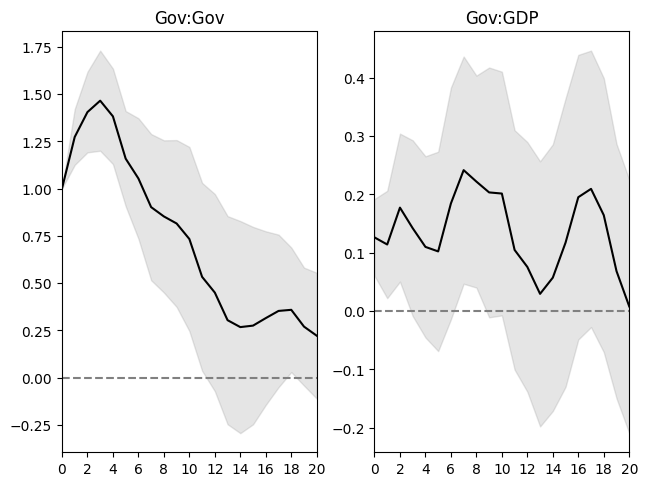

In [21]:
importlib.reload(lp)
lpmdl = lp.LP(dfiv,maxlags=4,shocks='Gov')
out, _ = lpmdl.estimate(20)
lp.plot_irfs(out,responses=['Gov','GDP'])

### Panel Data
Get data from JST's macrohistory database:

In [22]:
dfjst = pd.read_stata("https://www.macrohistory.net/app/download/9834512469/JSTdatasetR6.dta?t=1676279836")
dfjst2 = dfjst.copy()
dfjst.head()

,year,country,iso,ifs,pop,rgdpmad,rgdpbarro,rconsbarro,gdp,iy,...,eq_capgain,eq_dp,eq_capgain_interp,eq_tr_interp,eq_dp_interp,bond_rate,eq_div_rtn,capital_tr,risky_tr,safe_tr
0,1870,Australia,AUS,193,1775.0,3273.239437,13.836157,21.449734,208.78,0.109266,...,-0.070045,0.071417,NaN,NaN,NaN,0.049118,0.066415,NaN,NaN,NaN
1,1871,Australia,AUS,193,1675.0,3298.507463,13.936864,19.930801,211.56,0.104579,...,0.041654,0.065466,NaN,NaN,NaN,0.048446,0.068193,NaN,NaN,NaN
2,1872,Australia,AUS,193,1722.0,3553.426249,15.044247,21.085006,227.40,0.130438,...,0.108945,0.062997,NaN,NaN,NaN,0.047373,0.069861,NaN,NaN,NaN
3,1873,Australia,AUS,193,1769.0,3823.629169,16.219443,23.254910,266.54,0.124986,...,0.083086,0.064484,NaN,NaN,NaN,0.046720,0.069842,NaN,NaN,NaN
4,1874,Australia,AUS,193,1822.0,3834.796926,16.268228,23.458050,287.58,0.141960,...,0.119389,0.063503,NaN,NaN,NaN,0.046533,0.071085,NaN,NaN,NaN


In [23]:
dfjst = dfjst2.copy()
dfjst['country'] = pd.Categorical(dfjst['country'])
dfjst.set_index(['country','year'], inplace=True)
dfjst.sort_index(inplace=True)
idx = pd.IndexSlice
dfjst = dfjst.loc[idx[:,:2013],:]
dfjst['rgdppc'] = dfjst['rgdpbarro']
dfjst['mortgdp'] = 100 * dfjst['tmort'] / dfjst['gdp']
dfjst['hpreal'] = dfjst['hpnom'] / dfjst['cpi']

dfjst['hpreal'] = dfjst.groupby(level='country')['hpreal'].transform( \
    lambda x: x / x[idx[:,1990]].iloc[0] )

dfjst['lhpreal'] = np.log(dfjst['hpreal'])
dfjst['lhpy'] = dfjst['lhpreal'] - np.log(dfjst['rgdppc'])
dfjst['lhpy'] = dfjst.groupby(level='country')['lhpy'].transform( \
    lambda x: x - x[idx[:,1990]].iloc[0] )

dfjst['lhpreal'] = 100 * dfjst['lhpreal']
dfjst['lhpy'] = 100 * dfjst['lhpy']
dfjst['lrgdp'] = 100 * np.log(dfjst['rgdppc'])
dfjst['lcpi'] = 100 * np.log(dfjst['cpi'])
dfjst['lriy'] = 100 * np.log(dfjst['iy'] * dfjst['rgdppc'])
dfjst['cay'] = 100 * (dfjst['ca'] / dfjst['gdp'])
dfjst['tnmort'] = dfjst['tloans'] - dfjst['tmort']
dfjst['nmortgdp'] = 100 * (dfjst['tnmort'] / dfjst['gdp'])

dfjst = dfjst[['mortgdp','stir','ltrate','lhpy','lrgdp','lcpi','lriy','cay','nmortgdp']]
first_diff_vars = ['stir','ltrate','lhpy','lrgdp','lcpi','lriy','nmortgdp','mortgdp']
for v in first_diff_vars:
    dfjst['d_'+v] = dfjst[v] - dfjst.groupby(level='country')[v].shift(1)

#dfjst=dfjst.loc[idx[:,np.r_[1870:1914,1919:1939,1948:2014]],:]    
dfjst.tail()


mortgdp  stir   ltrate       lhpy       lrgdp        lcpi   
country year                                                                
USA     2009  42.651626  0.16  3.25667  -0.044900  458.746798  507.061569  \
        2010  40.402339  0.18  3.21417  -7.368303  460.448635  508.697855   
        2011  39.120131  0.10  2.78583 -14.961306  461.260781  511.801499   
        2012  37.783069  0.14  1.80250 -18.610363  462.751798  513.897384   
        2013  37.136649  0.11  2.35083 -14.076412  463.884258  515.367999   

                    lriy       cay   nmortgdp  d_stir  d_ltrate    d_lhpy   
country year                                                                
USA     2009  290.203120 -2.622830  17.830627   -1.76  -0.41000 -1.644084  \
        2010  288.876233 -2.870636  19.103030    0.02  -0.04250 -7.323403   
        2011  291.300822 -2.918627  19.542837   -0.08  -0.42834 -7.593003   
        2012  296.508897 -2.572364  20.320850    0.04  -0.98333 -3.649057   
        2013  298.902940 -2.015383  20.632659   -0.03   0.54833  4.533951   

               d_lrgdp    d_lcpi     d_lriy  d_nmortgdp  d_mortgdp  
country year                                                        
USA     2009 -3.446139 -0.348377 -15.944258   -1.965953  -0.497279  
        2010  1.701837  1.636286  -1.326887    1.272403  -2.249287  
        2011  0.812146  3.103644   2.424589    0.439807  -1.282209  
        2012  1.491017  2.095885   5.208074    0.778013  -1.337062  
        2013  1.132460  1.470615   2.394044    0.311809  -0.646420

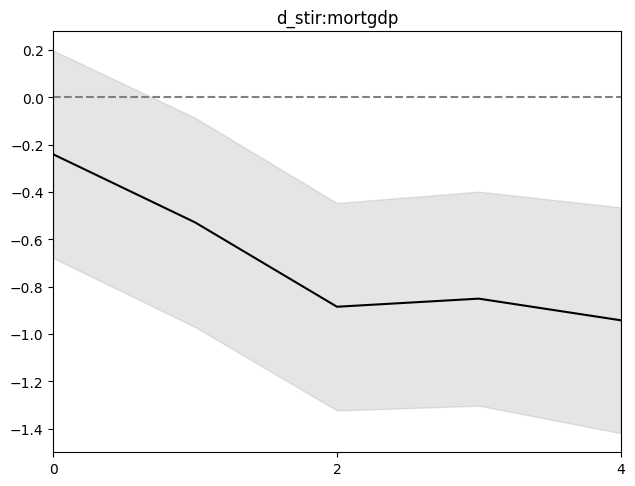

In [30]:
importlib.reload(lp)
lpmdl = lp.LP(dfjst, \
            sample=lambda df: df.index.get_level_values('year').isin(np.r_[1870:1914,1919:1939,1948:2014]), \
            responsevars='mortgdp', \
            shocks='d_stir', \
            cluster=True,
            endogvars={'cay':0, 
                  'd_stir':(1,2), 
                  'd_ltrate':(0,2), 
                  'd_lhpy':(0,2),
                  'd_lrgdp':(0,2),
                  'd_lcpi':(0,2),
                  'd_lriy':(0,2),
                  'd_nmortgdp':(0,2),
                  'd_mortgdp':(1,2)})
out, _ = lpmdl.estimate(4)
lp.plot_irfs(out)

### Panel with Interactions

We can also estimate impulse responses for several groups. To test this, let's figure out which region each country is in and then plot impulse responses separately for each region:

In [27]:
cc = coco.CountryConverter()
country_names = dfjst.index.get_level_values('country').unique()
regions = cc.data.loc[cc.data['ISO3'].isin(cc.convert(country_names)),'UNregion']
regions = regions.set_axis(country_names)
regions.rename_axis('country', inplace=True)
dfjstr=dfjst.join(regions)
dfjstr['UNregion']=pd.Categorical(dfjstr['UNregion'])

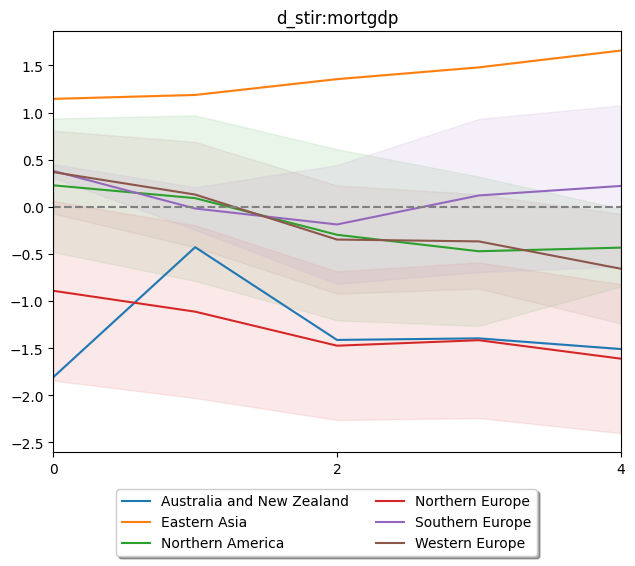

In [31]:
importlib.reload(lp)
lpmdl = lp.LP(dfjstr, \
            sample=lambda df: df.index.get_level_values('year').isin(np.r_[1870:1914,1919:1939,1948:2014]), \
            responsevars='mortgdp', \
            shocks='d_stir', \
            cluster=True, \
            interaction='UNregion', \
            endogvars={'cay':0, 
                  'd_stir':(1,2), 
                  'd_ltrate':(0,2), 
                  'd_lhpy':(0,2),
                  'd_lrgdp':(0,2),
                  'd_lcpi':(0,2),
                  'd_lriy':(0,2),
                  'd_nmortgdp':(0,2),
                  'd_mortgdp':(1,2)})
out, _ = lpmdl.estimate(4)
lp.plot_irfs(out)